# Sentiment Analysis of Twitter Text

## Load data and pre-processing

In [1]:
# import your libraries here
import pandas as pd
import nltk
import re
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vikramc18/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df_tweet = pd.read_csv('data/Tweets.csv')

In [3]:
df_tweet

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


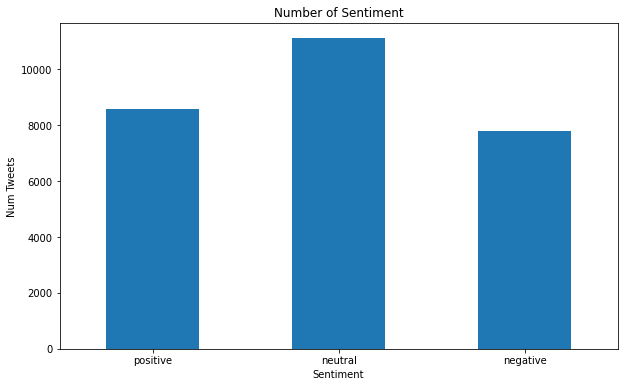

In [4]:
import matplotlib.pyplot as plt

#calculate sum of points for each team
df_groups = df_tweet.groupby(['sentiment'])['sentiment'].count().reindex(['positive', 'neutral','negative'])

#create bar plot with custom aesthetics
ax = df_groups.plot(kind='bar', title='Number of Sentiment',
               ylabel='Num Tweets', xlabel='Sentiment', figsize=(10, 6))

#rotate x-axis ticks vertically
plt.xticks(rotation=0)
plt.savefig('sentiment_dis.png', bbox_inches = 'tight')


### Data Cleaning
- remove tweets classified as 'neutral' so that we can perform binary classification
- remove non-string tweets

In [5]:
# https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
df_tweet_final = df_tweet[df_tweet['text'].apply(lambda x: isinstance(x, str))].reset_index()
df_tweet_final = df_tweet_final[df_tweet_final['sentiment'] != 'neutral'].reset_index()

In [6]:
df_tweet_final

,level_0,index,textID,text,selected_text,sentiment
0,1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
1,2,2,088c60f138,my boss is bullying me...,bullying me,negative
2,3,3,9642c003ef,what interview! leave me alone,leave me alone,negative
3,4,4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
4,6,6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
...,...,...,...,...,...,...
16358,27474,27475,b78ec00df5,enjoy ur night,enjoy,positive
16359,27475,27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
16360,27476,27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
16361,27477,27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive


In [7]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)
roberta_model = SentenceTransformer('paraphrase-distilroberta-base-v1');

def normalize_encode_tweet(tweet):
    norm = tokenizer.normalizeTweet(tweet)
    encoded = roberta_model.encode(norm)
    return encoded

emoji is not installed, thus not converting emoticons or emojis into text. Please install emoji: pip3 install emoji
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
from tqdm import tqdm

# show progress
tqdm.pandas()

# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
df_tweet_final['embedding'] =  df_tweet_final.progress_apply(lambda row: normalize_encode_tweet(row.text), axis=1)

100%|██████████| 16363/16363 [11:20<00:00, 24.05it/s]


In [9]:
df_tweet_final.to_csv('tweet_roberta_embeddings.csv', index=False)

In [10]:
df_tweet_final = pd.read_csv('tweet_roberta_embeddings.csv')

In [11]:
df_tweet_final.drop(df_tweet_final.columns[[0, 1, 2]], axis=1,inplace=True)

In [12]:
df_tweet_final.head()

,text,selected_text,sentiment,embedding
0,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,[ 9.30877551e-02 4.43676770e-01 1.10505581e-...
1,my boss is bullying me...,bullying me,negative,[-2.20891997e-01 -2.87244469e-02 1.46015704e-...
2,what interview! leave me alone,leave me alone,negative,[ 1.11802444e-02 -4.25624251e-01 1.02491967e-...
3,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,[ 1.77452222e-01 2.84410834e-01 5.99784851e-...
4,2am feedings for the baby are fun when he is a...,fun,positive,[-1.04325861e-01 2.68305153e-01 -1.53165251e-...


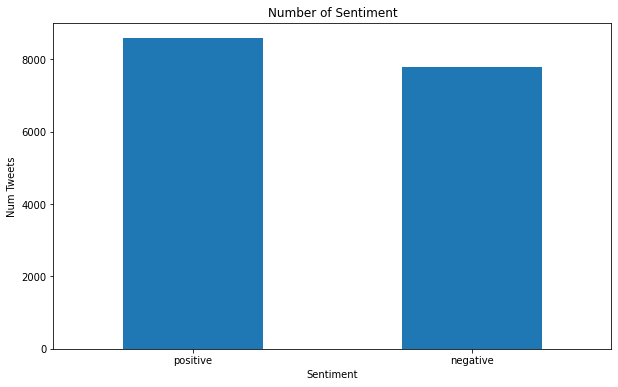

In [13]:
import matplotlib.pyplot as plt

#calculate sum of points for each team
df_groups = df_tweet_final.groupby(['sentiment'])['sentiment'].count().reindex(['positive','negative'])

#create bar plot with custom aesthetics
ax = df_groups.plot(kind='bar', title='Number of Sentiment',
               ylabel='Num Tweets', xlabel='Sentiment', figsize=(10, 6))

#rotate x-axis ticks vertically
plt.xticks(rotation=0)
plt.savefig('sentiment_dis2.png', bbox_inches = 'tight')

In [14]:
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [15]:
# test train split
# X = df_tweet_final['embedding'].values.tolist()
# when reading final df from csv
X = df_tweet_final['embedding'].apply(lambda s: ([float(x.strip(" \n")) for x in s.strip("[]").split()])).values.tolist()
y = df_tweet_final['sentiment'].map({'negative': 0, 'positive': 1}).values.tolist()

# train + test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

# train = 70%, test = 30% of original data

## Train Neural Net

### Data
Reformat X and y so that they can be passed into neural net

In [16]:
# training set
X_train_nn = np.asarray(X_train)
y_train_nn = y_train
y_train_nn = np.asarray([np.array(y) for y in y_train_nn])

# testing set
X_test_nn = np.asarray(X_test)
y_test_nn = y_test
y_test_nn = np.asarray([np.array(y) for y in y_test_nn])

### Training and Evaluation

Hyperparameters experimented with:
- Activation function for hidden layer
- Number of nodes in the hidden layer

In [17]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [18]:
# sklearn evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [19]:
def train_evaluate_nn(net):
    """
    trains the given neural net on our training data
    prints out model summary and metrics
    """
    # fit training data and validaiton data
    net.fit(X_train_nn, 
            y_train_nn, 
            epochs = 20, 
            batch_size = 10,
            verbose = 0)
    # predict x_test values
    y_pred_temp = net.predict(X_test_nn)
    # convert from probabilities to 0/1
    y_pred_net = [1 if y > 0.5 else 0 for y in y_pred_temp]
    
    # print metrics and net description
    net_accuracy = accuracy_score(y_test_nn, y_pred_net)
    net_precision = precision_score(y_test_nn, y_pred_net)
    net_recall = recall_score(y_test_nn, y_pred_net)
    net_f1 = f1_score(y_test_nn, y_pred_net)
    
    print(net.summary())    
    print(f'Neural Net Accuracy:  {net_accuracy}')
    print(f'Neural Net Precision: {net_precision}')
    print(f'Neural Net Recall:    {net_recall}')
    print(f'Neural Net F1 Score:  {net_f1}')

In [20]:
# 1 hidden layer w/ 128 nodes and relu activation
nn1 = Sequential(name='hidden_layer_with_128_nodes_relu_activation')
nn1.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn1.add(Dense(128, activation='relu', name='hidden'))
nn1.add(Dense(1, activation='sigmoid', name='output'))
nn1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn1)

154/154 [==============================] - 0s 854us/step
Model: "hidden_layer_with_128_nodes_relu_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8820533713587289
Neural Net Precision: 0.9465716829919858
Neural Net Recall:    0.8224371373307543
Neural Net F1 Score:  0.8801490374663631


In [21]:
# 1 hidden layer w/ 128 nodes and sigmoid activation
nn2 = Sequential(name='hidden_layer_with_128_nodes_sigmoid_activation')
nn2.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn2.add(Dense(128, activation='sigmoid', name='hidden'))
nn2.add(Dense(1, activation='sigmoid', name='output'))
nn2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn2)

154/154 [==============================] - 0s 875us/step
Model: "hidden_layer_with_128_nodes_sigmoid_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8889794255449175
Neural Net Precision: 0.8911042944785276
Neural Net Recall:    0.8990328820116054
Neural Net F1 Score:  0.895051030233006


In [22]:
# 1 hidden layer w/ 128 nodes and softmax activation
nn3 = Sequential(name='hidden_layer_with_128_nodes_softmax_activation')
nn3.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn3.add(Dense(128, activation='softmax', name='hidden'))
nn3.add(Dense(1, activation='sigmoid', name='output'))
nn3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn3)

154/154 [==============================] - 0s 815us/step
Model: "hidden_layer_with_128_nodes_softmax_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8569973518028111
Neural Net Precision: 0.8429872495446266
Neural Net Recall:    0.895164410058027
Neural Net F1 Score:  0.8682926829268293


In [23]:
# 1 hidden layer w/ 64 nodes and relu activation
nn4 = Sequential(name='hidden_layer_with_64_nodes_relu_activation')
nn4.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn4.add(Dense(64, activation='relu', name='hidden'))
nn4.add(Dense(1, activation='sigmoid', name='output'))
nn4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn4)

154/154 [==============================] - 0s 848us/step
Model: "hidden_layer_with_64_nodes_relu_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 213,377
Trainable params: 213,377
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8883683031167244
Neural Net Precision: 0.8850661625708884
Neural Net Recall:    0.9056092843326886
Neural Net F1 Score:  0.8952198852772467


In [24]:
# 1 hidden layer w/ 64 nodes and sigmoid activation
nn5 = Sequential(name='hidden_layer_with_64_nodes_sigmoid_activation')
nn5.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn5.add(Dense(64, activation='sigmoid', name='hidden'))
nn5.add(Dense(1, activation='sigmoid', name='output'))
nn5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn5)

154/154 [==============================] - 0s 846us/step
Model: "hidden_layer_with_64_nodes_sigmoid_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 213,377
Trainable params: 213,377
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8910165003055612
Neural Net Precision: 0.8975950349107835
Neural Net Recall:    0.895164410058027
Neural Net F1 Score:  0.8963780747627349


In [25]:
# 1 hidden layer w/ 64 nodes and softmax activation
nn6 = Sequential(name='hidden_layer_with_64_nodes_softmax_activation')
nn6.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn6.add(Dense(64, activation='softmax', name='hidden'))
nn6.add(Dense(1, activation='sigmoid', name='output'))
nn6.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn6)

154/154 [==============================] - 0s 964us/step
Model: "hidden_layer_with_64_nodes_softmax_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 213,377
Trainable params: 213,377
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8859238134039519
Neural Net Precision: 0.9396439426834564
Neural Net Recall:    0.837137330754352
Neural Net F1 Score:  0.8854337152209493


## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

### Training and Evaluation
Increased `max_iter` for all models as needed to avoid convergence warnings

Hyperparameters:
- `solver`: the algorithm to use in the optimization process
- `penalty`: norm of the penalty term - not all penalties can be used with all solvers

In [27]:
def train_evaluate_logistic_regression(model, description):
    # train model
    trained_model = model.fit(X_train, y_train)
    # predict
    y_pred = trained_model.predict(X_test)
    
    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(description)
    print(f'Logistic Regression Accuracy:  {accuracy}')
    print(f'Logistic Regression Precision: {precision}')
    print(f'Logistic Regression Recall:    {recall}')
    print(f'Logistic Regression F1 Score:  {f1}')

In [28]:
# lbfgs, l2
log_reg1 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='lbfgs',
                              random_state=1)

train_evaluate_logistic_regression(log_reg1, 'lbfgs, l2')

lbfgs, l2
Logistic Regression Accuracy:  0.8877571806885313
Logistic Regression Precision: 0.8988235294117647
Logistic Regression Recall:    0.8866537717601547
Logistic Regression F1 Score:  0.8926971762414799


In [29]:
# lbgfs, none
log_reg2 = LogisticRegression(max_iter=500,
                              penalty='none',
                              solver='lbfgs',
                              random_state=1)

train_evaluate_logistic_regression(log_reg2, 'lbfgs, none')

lbfgs, none
Logistic Regression Accuracy:  0.8824607863108576
Logistic Regression Precision: 0.8955870764381403
Logistic Regression Recall:    0.8793036750483559
Logistic Regression F1 Score:  0.8873706812414601


In [30]:
# newton-cg, l2
log_reg3 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='newton-cg',
                              random_state=1)

train_evaluate_logistic_regression(log_reg3, 'newton-cg, l2')

newton-cg, l2
Logistic Regression Accuracy:  0.8877571806885313
Logistic Regression Precision: 0.8988235294117647
Logistic Regression Recall:    0.8866537717601547
Logistic Regression F1 Score:  0.8926971762414799


In [31]:
# newton-cg, none
log_reg4 = LogisticRegression(max_iter=500,
                              penalty='none',
                              solver='newton-cg',
                              random_state=1)

train_evaluate_logistic_regression(log_reg4, 'newton-cg, none')

newton-cg, none
Logistic Regression Accuracy:  0.882664493786922
Logistic Regression Precision: 0.8959400867165944
Logistic Regression Recall:    0.8793036750483559
Logistic Regression F1 Score:  0.8875439281530653


In [32]:
# liblinear, l2
log_reg5 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='liblinear',
                              random_state=1)

train_evaluate_logistic_regression(log_reg5, 'liblinear, l2')

liblinear, l2
Logistic Regression Accuracy:  0.8877571806885313
Logistic Regression Precision: 0.8981989036805011
Logistic Regression Recall:    0.8874274661508704
Logistic Regression F1 Score:  0.8927806966335863


In [33]:
# liblinear, l1
log_reg6 = LogisticRegression(max_iter=500,
                              penalty='l1',
                              solver='liblinear',
                              random_state=1)

train_evaluate_logistic_regression(log_reg6, 'liblinear, l1')

liblinear, l1
Logistic Regression Accuracy:  0.8899979629252394
Logistic Regression Precision: 0.9017681728880157
Logistic Regression Recall:    0.8878143133462283
Logistic Regression F1 Score:  0.8947368421052632


In [34]:
# sag, l2
log_reg7 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='sag',
                              random_state=1)

train_evaluate_logistic_regression(log_reg7, 'sag, l2')

sag, l2
Logistic Regression Accuracy:  0.8877571806885313
Logistic Regression Precision: 0.8988235294117647
Logistic Regression Recall:    0.8866537717601547
Logistic Regression F1 Score:  0.8926971762414799


In [35]:
# sag, none
log_reg8 = LogisticRegression(max_iter=500,
                              penalty='none',
                              solver='sag',
                              random_state=1)

train_evaluate_logistic_regression(log_reg8, 'sag, none')

sag, none
Logistic Regression Accuracy:  0.882664493786922
Logistic Regression Precision: 0.8959400867165944
Logistic Regression Recall:    0.8793036750483559
Logistic Regression F1 Score:  0.8875439281530653


In [36]:
# saga, l2
log_reg9 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='saga',
                              random_state=1)

train_evaluate_logistic_regression(log_reg9, 'saga, l2')

saga, l2
Logistic Regression Accuracy:  0.8877571806885313
Logistic Regression Precision: 0.8988235294117647
Logistic Regression Recall:    0.8866537717601547
Logistic Regression F1 Score:  0.8926971762414799


In [37]:
# saga, l1
log_reg10 = LogisticRegression(max_iter=500,
                               penalty='l1',
                               solver='saga',
                               random_state=1)

train_evaluate_logistic_regression(log_reg10, 'saga, l1')

saga, l1
Logistic Regression Accuracy:  0.8899979629252394
Logistic Regression Precision: 0.9017681728880157
Logistic Regression Recall:    0.8878143133462283
Logistic Regression F1 Score:  0.8947368421052632


In [38]:
# saga, none
log_reg11 = LogisticRegression(max_iter=800,
                               penalty='none',
                               solver='saga',
                               random_state=1)

train_evaluate_logistic_regression(log_reg11, 'saga, none')

saga, none
Logistic Regression Accuracy:  0.8828682012629864
Logistic Regression Precision: 0.8959810874704491
Logistic Regression Recall:    0.8796905222437137
Logistic Regression F1 Score:  0.8877610774936561


# Citations

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
- https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
- https://huggingface.co/docs/transformers/model_doc/bertweet#transformers.BertweetTokenizer